# 빅데이터 분석 특강 (9주차_2) 5월2일

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [Special Topics in Big Data Analysis]

## import

In [128]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.experimental.numpy as tnp

In [129]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

## 중간고사 관련 잡담 

### 중간고사 3번문제

train / test 나눠서 하는 회귀분석, 단순회귀분석이 오버피팅이 아닌 이유basis가 직교하기 때문,

상관계수가 0으로 가기 때문! $\to$ 직교하기 때문에

세미파라메틱모델: 무조건 변수가 많다고 오버피팅이 일어나는 것은 아니다.

직교하는 변수가 3개면 절대 선형결합이 될 수 없다.

색의 삼원색, 빨/파/노 가 각각 basis로 볼 때, 보라색/파란색/빨간색도 basis로 볼 수 있음, 보라색에서 빨간색으로 빼낼 수 있으니까

직선의 베이시스 - 기울기와 

오차항을 다 따라가? 오버피팅.. 다시 듣기..

`-` 특이한모형: 오버핏이 일어날 수 없는 모형이다.

- 유의미한 coef: 상수항(bias), $\cos(t)$의 계수, $\cos(2t)$의 계수, $\cos(5t)$의 계수.
- 유의미하지 않은 coef: $\cos(3t)$의 계수, $\cos(4t)$의 계수
- 유의미하지 않은 계수는 $n$이 커질수록 0으로 추정된다 = $\cos(3t)$와 $\cos(5t)$는 사용자가 임의로 제외하지 않아도 결국 모형에서 알아서 제거된다 = overfit이 일어나지 않는다. 모형이 알아서 유의미한 변수만 뽑아서 fit하는 느낌

`-` 3번문제는 overfit이 일어나지 않는다. 이러한 신기한 일이 일어나는 이유는 모든 설명변수가 직교하기 때문임.

- 이런 모형의 장점: overfit이 일어날 위험이 없으므로 train/test로 나누어 학습할 이유가 없다. (샘플만 버리는 꼴, test에 빼둔 observation까지 모아서 학습해 $\beta$를 좀 더 정확히 추론하는게 차라리 더 이득)
- 이러한 모형에서 할일: 추정된 계수들이 0인지 아닌지만 test하면 된다. (이것을 유의성검정이라고 한다)

`-` 직교기저의 예시

- 빨강과 파랑을 255,255만큼 섞으면 보라색이 된다.
- 빨강과 파랑과 노랑을 각각 255,255,255만큼 섞으면 검은색이 된다.
- 임의의 어떠한 색도 빨강,파랑,노랑의 조합으로 표현가능하다. 즉 $\text{color}= \text{red}*\beta_1 + \text{blue}*\beta_2 + \text{yellow}*\beta_3$이다.
- (빨,파,노)는 색을 표현하는 basis이다. (적절한 $\beta_1,\beta_2,\beta_3$을 구하기만 하면 임의의 색도 표현가능)
- (빨,보,노)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요할때 보라색-빨간색을 하면되니까)
- (빨,보,검)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요하면 보라색-빨간색을 하면되고, 노란색이 필요하면 검정색-보라색을 하면 되니까)
- (빨,파,노)는 직교기저이다.

`-` 3번에서 알아둘 것: (1) 직교기저의 개념 (추후 재설명) (2) 임의의 색을 표현하려면 3개의 basis가 필요함

### 중간고사 1-(3)번 문제

`-` 그림을 그려보자.

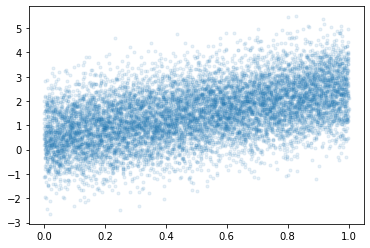

In [100]:
_x= tf.constant(np.arange(1,10001)/10000)
_y= tnp.random.randn(10000) + (0.5 + 2*_x) 
plt.plot(_x,_y,'.',alpha=0.1)

`-` 저것 꼭 10000개 다 모아서 loss계산해야할까?

간격이 10으로 잡혀 건너뛰며 데이터를 가져옴

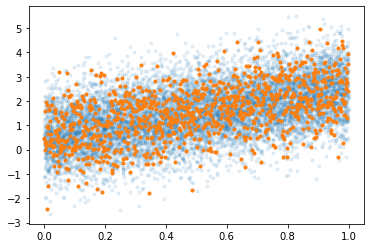

In [101]:
plt.plot(_x,_y,'.',alpha=0.1)
plt.plot(_x[::10],_y[::10],'.')

`-`  대충 이정도만 모아서 해도 비슷하지 않을까? $\to$ 해보자!

## 경사하강법과 확률적경사하강법

`-`  10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$ = $(x_1,y_1),\dots, (x_{10},y_{10})$

### ver1: 모든 샘플을 사용하여 slope계산

(epoch1) $loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) $loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

...

경사하강법

### ver2: 하나의 샘플만 사용하여 slope계산 

(epoch1) 
- $loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_2-\beta_0-\beta_1x_2)^2 \quad \to \quad slope \quad \to \quad update$
- ...
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) 
- $loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_2-\beta_0-\beta_1x_2)^2 \quad \to \quad slope \quad \to \quad update$
- ...
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

...

여기서 에폭 3번 돌리면 for문도 3번 돌아가..

ver 1과 ver 2의 차이점
- 동일 epoc 대비 효과가 좋은 것은 ver 1
- 동일 iteration 대비 효과가 좋은 것은 ver 1
- 양으로 승부 ver 2 질로 승부 ver 1

계산할 때 조금 더 정확한 방법은 ver 1이라고 할 수 있다.

### ver3: $m(\leq n)$개의 샘플만 사용하여 slope계산

$m=3$이라고 하자. 

(epoch1) 
- $loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) 
- $loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

...

미니배치를 만들어서 샘플만큼만 업데이트

여기서 n이 3이면은 ver 1과 같아지지

### $\star$ 용어의 정리 

#### 옛날 (좀 더 엄밀)

`-` ver1: gradient descent, batch gradient descent 


`-` ver2: stochastic gradient descent
- 확률적 경사하강법

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient descent

#### 요즘 

`-` ver1: gradient descent


`-` ver2: stochastic gradient descent with batch size = 1 

`-` ver3: stochastic gradient descent 
- https://www.deeplearningbook.org/contents/optimization.html, 알고리즘 8-1 참고. p291

note: 이렇게 많이 쓰는 이유? ver1,2는 사실상 없는 방법이므로

---

**Algorithm 8.1 Stochastic gradient descent (SGD) update** 위에서 참고한 알고리즘

Require: Learning rate schedule $\epsilon_1, \epsilon_2, \dots$

Require: Initial paramete $\theta$
    
$k \gets 1$

while stopping criterion not met do

sample a minibatch of m examples from the training set $\{ x^{(1)},\dots,x^{(m)} \}$ with

corresponding targets $y^{(i)}$.

Compute gradient estimate: $\hat{g} \gets \frac{1}{m} \nabla_{\theta} \sum_i L(f(x^{(i)} ; \theta), y^{(i)} )$

Apply update: $\theta \leftarrow \theta - \epsilon_k \hat{g}$

$k \leftarrow k + 1$

end while

---

### ver1,2,3 이외에 좀 더 지저분한 것들이 있다. 

`-` ver2,3에서 샘플을 셔플할 수도 있다. 
- ver 3에서 남는 데이터들이 이상치면 어떡해?

`-` ver3에서 일부 샘플이 학습에 참여 안하는 버전도 있다. 
- 계속 샘플하면 복원이라 안 뽑히는 샘플이 있을 수도 있다.
- n이 커지면 이 영향도 무시할만하게 된다.

`-` 개인적 생각: 크게 3개 정도만 알면 괜찮고 나머지는 그렇게 유의미하지 않아 보인다. 

### Discussion 

`-` 핵심개념 
- **메모리사용량: ver1 > ver3 > ver2**
    - 틀린 설명이 많은 부분..
- 계산속도: ver1 > ver3 > ver2 
- local-min에 갇힘: ver1 > ver3 > ver2
    - local minimum에 빠졌다가 탈출.. global minimum으로~ 가는 경우도 있다
    - local minimum에 갇힌다? = local minimum을 잘 찾는다

![](https://www.mathsisfun.com/algebra/images/function-max-global.svg)

`-` 본질: GPU 메모리가 한정되어 있어서 ver1을 쓰지는 못한다. GPU 메모리를 가장 적게쓰는것은 ver2인데 이것은 너무 불안정하다. 

`-` 틀리진 않지만 어색한 블로그 정리 내용들 
- 경사하강법은 종종 국소최소점에 갇히는 문제가 있다. 이를 해결하기 위해서 등장한 방법이 확률적 경사하강법이다.
    - 확률적경사하강법도 local minimum애 빠지는 경우가 있는데?
    - 전혀 틀린 말은 아지지만 그걸 의도하고 만든 것은 아니다.
    - 어쩌다 보니까 확률적 경사하강법이 더 잘 빠져나오는것
- 경사하강법은 계산시간이 오래걸린다. 계산을 빠르게 하기 위해서 등장한 방법이 확률적 경사하강법이다.
    - 1회 업데이트는 빠르게 계산함.
    - 하지만 그것이 최적의 $\beta$를 빠르게 얻을 수 있다는 의미는 아니다.
    - 계산이 빠르단 의미는 1회 업데이트 하는 속도가 빠르다는 의미임. 최종적으루 수렴을 빨리시키는지는 미지수임. 이것은 돌려봐야 안다.

모든 객체를 constant로 불변형 만들면 메모리를 많이 써서 variable 쓴다 했잖아
- 결국 GPU 언제 쓰느냐, gridient를 업데이트할 떄 쓰는!
- gradient 미분하려면 loss 필요하고 , 또 y, yhat이 있어야 하잖아?
- 그런데 메모리 너무 많이 필요
- 그래서 미니배치가 유용하다는 거지
- 나눠서 많이 올릴 수 있으니까

## fashion_mnist 모듈 

### tf.keras.datasets.fashion_mnist.load_data()

In [102]:
type(tf.keras.datasets.fashion_mnist)

module

In [103]:
type(tf.keras.datasets.fashion_mnist.load_data)

function

__call__ call of function

In [104]:
dir(tf.keras.datasets.fashion_mnist.load_data)

['__annotations__',
 '__builtins__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_keras_api_names',
 '_keras_api_names_v1']

In [105]:
a=123.1

In [106]:
#collapse_output
dir(a)

['__abs__',
 '__add__',
 '__bool__',
 '__ceil__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floor__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getformat__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__le__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rdivmod__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmod__',
 '__rmul__',
 '__round__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__set_format__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__trunc__',
 'as_integer_ratio',
 'conjugate',
 'fromhex',
 'hex',
 'imag',
 'is_integer',
 'real']

위 목록에서 괄호를 열고 닫아 실행되는 코드들

In [107]:
a.__add__(1)

124.1

### 데이터생성 및 탐색

`-` tf.keras.datasets.fashion_mnist.load_data()를 이용한 데이터 생성 

In [108]:
#collapse_output
tf.keras.datasets.fashion_mnist.load_data??

Signature: tf.keras.datasets.fashion_mnist.load_data()
Source:   
@keras_export('keras.datasets.fashion_mnist.load_data')
def load_data():
  """Loads the Fashion-MNIST dataset.

  This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images. This dataset can be used as
  a drop-in replacement for MNIST.

  The classes are:

  | Label | Description |
  |:-----:|-------------|
  |   0   | T-shirt/top |
  |   1   | Trouser     |
  |   2   | Pullover    |
  |   3   | Dress       |
  |   4   | Coat        |
  |   5   | Sandal      |
  |   6   | Shirt       |
  |   7   | Sneaker     |
  |   8   | Bag         |
  |   9   | Ankle boot  |

  Returns:
    Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

  **x_train**: uint8 NumPy array of grayscale image data with shapes
    `(60000, 28, 28)`, containing the training data.

  **y_train**: uint8 NumPy array of labels (integers in range 0-9)
    with shape `(60000,)` for the t

`-` 함수의 return값을 확인하면 (x_train, y_train), (x_test, y_test)로 결과를 받아야 코드가 예뻐짐을 알 수 있다.

```python
return (x_train, y_train), (x_test, y_test)
```

In [109]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

`-` 데이터의 확인

In [110]:
type(x_train)

numpy.ndarray

numpy네

In [111]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

train 대 test를 6대1로 나눴구나

- x는 60000개의 관측치(이미지의 수)를 가지고 있는듯 보인다.
- 하나의 obs에 대한 x의 차원은 (28,28)이다.
- 하나의 obs에 대한 y의 차원은 스칼라다.

`-` 하나의 관측치가 무엇을 의미할까?

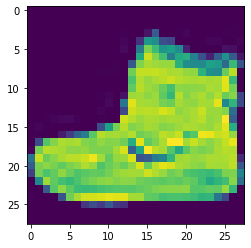

In [112]:
plt.imshow(x_train[0])

신발을 9라고 정의한 건가!

In [113]:
y_train[0]

9

- 신발이미지=x, 신발임의의미하는숫자9=y

In [114]:
np.where(y_train==9)

(array([    0,    11,    15, ..., 59932, 59970, 59978]),)

In [115]:
y_train[11]

9

9나왔다

- y==9인 다른 obs조사

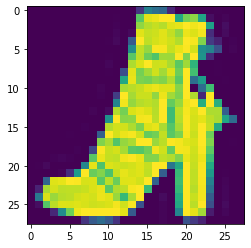

In [116]:
plt.imshow(x_train[11])

역시 신발이 나왔다

신발이 9라고 카테고리화 된것을 조금 더 확신할 수 있겠다.

In [117]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### 데이터구조 

In [118]:
x_train.shape

(60000, 28, 28)

- $X$: (n,28,28), 픽셀크기가 $28\times28$ 인 이미지

- ${\bf y}$: (n,), 이미지에 대응하는 라벨 (0~9까지의 숫자로 되어있다)

In [119]:
y_train[:20]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4],
      dtype=uint8)

## 예제1

### 데이터 정리 

`-` y=0,1에 대응하는 이미지만 정리하자. (우리가 배운건 로지스틱이니깐)

In [120]:
(x_train[(y_train == 0) | (y_train == 1)]).shape

(12000, 28, 28)

우리가 계산하기 위해 array로 표현

In [121]:
28*28

784

In [122]:
y=y_train[(y_train == 0) | (y_train == 1)].reshape(-1,1)
X=x_train[(y_train == 0) | (y_train == 1)].reshape(-1,784)

In [123]:
y,X

(array([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [124]:
yy= y_test[(y_test == 0) | (y_test == 1)].reshape(-1,1)
XX= x_test[(y_test == 0) | (y_test== 1)].reshape(-1,784)

In [125]:
yy,XX

(array([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

In [126]:
X.shape,y.shape, XX.shape,yy.shape

((12000, 784), (12000, 1), (2000, 784), (2000, 1))

### 풀이1: 은닉층을 포함한 신경망  // epochs=100

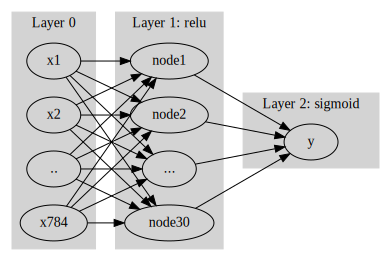

In [2]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: sigmoid"
}
''')

In [130]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='sgd',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 0s 141ms/step - loss: 220.9145
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 6799.9707
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7045
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7012
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7004
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6997
Epoch 7/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6991
Epoch 8/100
1/1 [==============================] - 0s 8ms/step - loss: 0.6985
Epoch 9/100
1/1 [==============================] - 0s 7ms/step - loss: 0.6979
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6976
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6973
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6970
Epoch 13/100
1/1 [==============================] - 0s

In [131]:
net(X)

<tf.Tensor: shape=(12000, 1), dtype=float32, numpy=
array([[0.49997538],
       [0.49997538],
       [0.49997538],
       ...,
       [0.49997538],
       [0.49997538],
       [0.49997538]], dtype=float32)>

In [133]:
y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=uint8)

계산된 결과 보니 비슷한 것 같나..

In [134]:
np.mean((net(X)>0.5) == y.reshape(12000,1))

0.5000833333333333

train의 정확률

In [69]:
np.mean((net(XX)>0.5) == yy.reshape(2000,1))

0.5

test의 정확률

local minimum에 빠진 것 같음..

초기값이 문제가 아니라, 최적화 방법이 안 좋은 것.. 확률적 경사 하강법..

랜덤 시드에 따라 확연히 달라지는 정확률

### 풀이2: 옵티마이저 개선

In [135]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 0s 158ms/step - loss: 220.9145
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 88.9451
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 7.5897
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 33.7528
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 40.2279
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 28.9659
Epoch 7/100
1/1 [==============================] - 0s 6ms/step - loss: 16.5115
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 9.4901
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 6.2021
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2415
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 5.5175
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5907
Epoch 13/100
1/1 [==============================] - 

In [136]:
np.mean((net(X)>0.5) == y.reshape(12000,1))

0.98125

train의 정확률

In [137]:
np.mean((net(XX)>0.5) == yy.reshape(2000,1))

0.977

adam 쓰니까 확연히 달라진 결과

### 풀이3: 컴파일시 metrics=['accuracy'] 추가

In [138]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 0s 181ms/step - loss: 220.9145 - accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 88.9451 - accuracy: 0.5073
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 7.5897 - accuracy: 0.8208
Epoch 4/100
1/1 [==============================] - 0s 7ms/step - loss: 33.7528 - accuracy: 0.5972
Epoch 5/100
1/1 [==============================] - 0s 7ms/step - loss: 40.2279 - accuracy: 0.5723
Epoch 6/100
1/1 [==============================] - 0s 7ms/step - loss: 28.9659 - accuracy: 0.6442
Epoch 7/100
1/1 [==============================] - 0s 7ms/step - loss: 16.5115 - accuracy: 0.8061
Epoch 8/100
1/1 [==============================] - 0s 7ms/step - loss: 9.4901 - accuracy: 0.8947
Epoch 9/100
1/1 [==============================] - 0s 7ms/step - loss: 6.2021 - accuracy: 0.9355
Epoch 10/100
1/1 [==============================] - 0s 7ms/step - loss: 5.2415 - accuracy: 0.9404
Epoch 11/100
1/1 [==

In [139]:
np.mean((net(X)>0.5) == y.reshape(12000,1))

0.98125

train의 정확률

In [140]:
np.mean((net(XX)>0.5) == yy.reshape(2000,1))

0.977

옵션을 넣어야 정확률 쉽게 보는 옵션 사용 가능

In [141]:
net.evaluate(X,y)

375/375 [==============================] - 1s 3ms/step - loss: 0.4860 - accuracy: 0.9812


[0.4860472083091736, 0.981249988079071]

train의 정확률

In [142]:
net.evaluate(XX,yy)

63/63 [==============================] - 0s 3ms/step - loss: 0.4298 - accuracy: 0.9770


[0.42978307604789734, 0.9769999980926514]

metric; 모형이 좋은지 판단할 수 있는 근거

### 풀이4: 확률적경사하강법 이용 // epochs=10

In [143]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=10,batch_size=120) 

Epoch 1/10
100/100 [==============================] - 1s 3ms/step - loss: 5.6482 - accuracy: 0.9418
Epoch 2/10
100/100 [==============================] - 0s 3ms/step - loss: 0.5070 - accuracy: 0.9792
Epoch 3/10
100/100 [==============================] - 0s 3ms/step - loss: 0.3774 - accuracy: 0.9820
Epoch 4/10
100/100 [==============================] - 0s 3ms/step - loss: 0.3497 - accuracy: 0.9829
Epoch 5/10
100/100 [==============================] - 0s 3ms/step - loss: 0.2401 - accuracy: 0.9855
Epoch 6/10
100/100 [==============================] - 0s 3ms/step - loss: 0.2218 - accuracy: 0.9868
Epoch 7/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1802 - accuracy: 0.9891
Epoch 8/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1690 - accuracy: 0.9886
Epoch 9/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1111 - accuracy: 0.9908
Epoch 10/10
100/100 [==============================] - 0s 3ms/step - loss: 0.1261 - accuracy: 0.9902

정확률 높게 시작하는 이유
- 이제까지 업데이트 한 번한 결과인데
- 이 결과는 100번 업데이트한 결과이기 때문에 정확률이 높은 상태에서 시작하게 된다.

In [144]:
net.evaluate(X,y)

375/375 [==============================] - 1s 3ms/step - loss: 0.0745 - accuracy: 0.9937


[0.07449778914451599, 0.9936666488647461]

train의 정확률

In [145]:
net.evaluate(XX,yy)

63/63 [==============================] - 0s 3ms/step - loss: 0.2422 - accuracy: 0.9860


[0.24218188226222992, 0.9860000014305115]

In [146]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=10,batch_size=60) 

Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 3.5760 - accuracy: 0.9584
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.4331 - accuracy: 0.9831
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.3836 - accuracy: 0.9838
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2980 - accuracy: 0.9865
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.2001 - accuracy: 0.9881
Epoch 6/10
200/200 [==============================] - 1s 3ms/step - loss: 0.1427 - accuracy: 0.9893
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0874 - accuracy: 0.9900
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0442 - accuracy: 0.9884
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0319 - accuracy: 0.9892
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0214 - accuracy: 0.9902

batch_size 60 했더니 200번씩 돌아가네

```python
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=10,batch_size=1) 
```
12000번씩 돌아가고 끝나게지..

batch_size 정답은 없다.

64,128,.. 보통 올라가는 배치사이즈로 메모리를 쓰게 놀린다.

---

과제